In [1]:
import numpy as np
import cv2
from skimage import exposure
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.linalg import eigh
import numpy as np
from scipy.ndimage import gaussian_filter
import math



In [3]:

imsize = 400

# Load and resize the content image
content = cv2.imread("./images/house 2-small.jpg")
content = cv2.cvtColor(content, cv2.COLOR_BGR2RGB)

content_copy = content.copy()
content = content[0:imsize, 0:imsize]

# Load and resize the style image
style = cv2.imread("./images/starry-night - small.jpg")
style = cv2.cvtColor(style, cv2.COLOR_BGR2RGB)
style = style[0:imsize, 0:imsize]

(-0.5, 399.5, 399.5, -0.5)

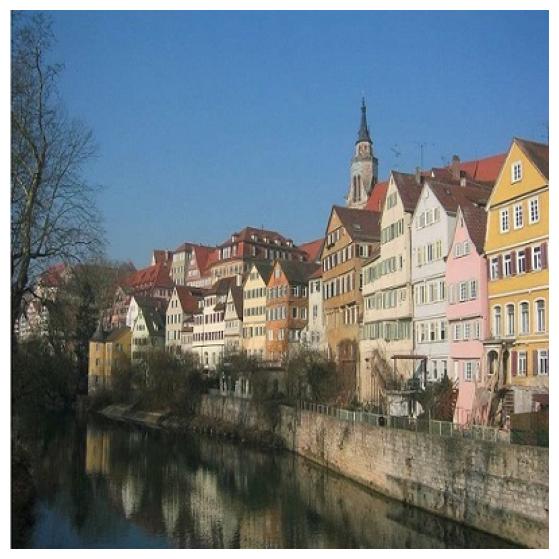

In [4]:
plt.figure(figsize=(15,7))
plt.imshow(content)
plt.axis("off")

(-0.5, 399.5, 399.5, -0.5)

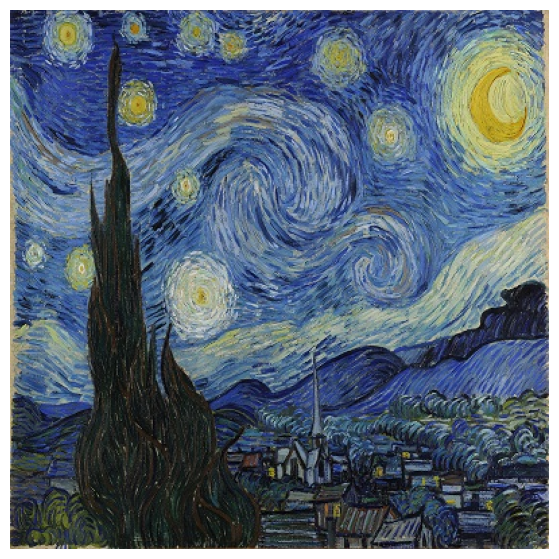

In [5]:
plt.figure(figsize=(15,7))
plt.imshow(style)
plt.axis("off")

In [36]:
# import numpy as np
# from scipy.signal import correlate2d
# from scipy.ndimage import rotate
import math

# def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
#     opt = 1
#     S = S.reshape((h, w, c))
#     RX = X[R.astype(bool)]
#     min_l2 = np.inf

#     if opt == 0:
#         P = Pp
#         temp = np.tile(RX, (1, P.shape[1]))
#         sqr = np.sum((temp - P)**2, axis=0)
#         idx = np.argmin(sqr)
#         ks, ls = np.unravel_index(idx, ((w - Q_size + 1), (h - Q_size + 1)))
#         ks, ls = ks+1, ls+1

#     elif opt == 1:
#         RXp = np.dot(Vp.T, (RX - mp))
#         dif = np.tile(RXp, (1, Pp.shape[1])) - Pp
#         sqr = np.sum(dif**2, axis=0)
#         sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.size)
#         idx = np.argmin(sqr)
#         ls, ks = np.unravel_index(int(np.ceil(idx / 4)), ((np.floor(((w - Q_size + 1) - 1) / Pstride) + 1), (np.floor(((h - Q_size + 1) - 1) / Pstride) + 1)))
#         ks = int((ks - 1) * Pstride + 1)
#         ls = int((ls - 1) * Pstride + 1)

#         ang = idx % 4  # equivalent to mod(idx, 4)

#     elif opt == 2:
#         # htm = vision.TemplateMatcher('Metric', 'Sum of squared differences')
#         # Loc = step(htm, rgb2gray(S), rgb2gray(reshape(RX, [Q_size Q_size 3])))
#         # ks = floor(Loc(2) - Q_size / 2); ls = floor(Loc(1) - Q_size / 2)
#         pass  # You can implement this part if needed

#     z = S[ks:ks+Q_size, ls:ls+Q_size, :]
#     # maybe compute outside so no need to pass S
#     # z = edge_smooth(z, gap);
#     z = z.ravel()

#     return ks, ls, z, ang


def nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap):
    opt = 1
    S = S.reshape((h, w, c))
    RX = X[R.astype(bool)]
    min_l2 = np.inf

    if opt == 0:
        P = Pp
        temp = np.tile(RX, (1, P.shape[1]))
        sqr = np.sum((temp - P)**2, axis=0)
        idx = np.argmin(sqr)
        ks, ls = np.unravel_index(idx, ((h - Q_size + 1), (w - Q_size + 1)))

    elif opt == 1:
        RXp = np.dot(Vp.T, (RX - mp))
        dif = np.tile(RXp, (1, Pp.shape[1])) - Pp
        sqr = np.sum(dif**2, axis=0)
        sqr = sqr + 0.1 * np.min(sqr) * np.random.randn(sqr.size)
        idx = np.argmin(sqr)
        ks, ls = np.unravel_index(int(np.ceil(idx / 4)), ((math.floor(((h - Q_size + 1) - 1) / Pstride) + 1), (math.floor(((w - Q_size + 1) - 1) / Pstride) + 1)))
        ks = int((ks - 1) * Pstride + 1)
        ls = int((ls - 1) * Pstride + 1)
        ang = (idx + 3) % 4  # Equivalent to mod(idx + 3, 4)

        print("RXp shape:", RXp.shape)
        print("Pp shape:", Pp.shape)


    elif opt == 2:
        pass

    z = S[ks:ks+Q_size, ls:ls+Q_size, :]
    z = z.ravel()

    return ks, ls, z, ang


In [32]:
def irls(R, X, z):
    tNc, Nij = R.shape
    I = 5  # Max number of IRLS iterations
    Xk = X.copy()  # Current estimate
    r = 0.8
    unsampled_pixs = np.double(np.sum(R, axis=1) > 0)  # Prevent black bar artifacts from gap

    for k in range(I):
        A = unsampled_pixs  # Prevent black bar artifacts from gap
        B = Xk * unsampled_pixs

        for i in range(Nij):
            w = np.sum((Xk[R[:, i].astype(bool)] - z[:, i])**2 + 1e-10)**((r-2)/2)
            A = A + w * R[:, i]
            temp = np.zeros_like(R[:, i])
            temp[R[:, i].astype(bool)] = z[:, i]
            B = B + w * temp

        Xk = (1 / (A + 1e-10)) * B

    return Xk

In [37]:
import numpy as np

# Define the Recursive Filter function
def RF(img, sigma_s, sigma_r, num_iterations=3, joint_image=None):
    I = np.double(img)

    if joint_image is not None:
        J = np.double(joint_image)

        if I.shape[:2] != J.shape[:2]:
            raise ValueError('Input and joint images must have equal width and height.')
    else:
        J = I

    h, w, num_joint_channels = J.shape

    # Compute the domain transform
    dIcdx = np.diff(J, axis=1)
    dIcdy = np.diff(J, axis=0)

    dIdx = np.zeros((h, w))
    dIdy = np.zeros((h, w))

    for c in range(num_joint_channels):
        dIdx[:, 1:] += np.abs(dIcdx[:, :, c])
        dIdy[1:, :] += np.abs(dIcdy[:, :, c])

    dHdx = (1 + sigma_s / sigma_r * dIdx)
    dVdy = (1 + sigma_s / sigma_r * dIdy)

    dVdy = dVdy.T

    # Perform the filtering
    N = num_iterations
    F = I.copy()
    sigma_H = sigma_s

    for i in range(num_iterations):
        sigma_H_i = sigma_H * np.sqrt(3) * 2**(N - (i + 1)) / np.sqrt(4**N - 1)

        F = TransformedDomainRecursiveFilter_Horizontal(F, dHdx, sigma_H_i)
        F = image_transpose(F)

        F = TransformedDomainRecursiveFilter_Horizontal(F, dVdy, sigma_H_i)
        F = image_transpose(F)

    return F.astype(img.dtype)

def TransformedDomainRecursiveFilter_Horizontal(I, D, sigma):
    a = np.exp(-np.sqrt(2) / sigma)
    F = I.copy()
    V = a**D

    h, w, num_channels = I.shape

    for i in range(1, w):
        for c in range(num_channels):
            F[:, i, c] += V[:, i] * (F[:, i - 1, c] - F[:, i, c])

    for i in range(w-2, -1, -1):
        for c in range(num_channels):
            F[:, i, c] += V[:, i + 1] * (F[:, i + 1, c] - F[:, i, c])

    return F

def image_transpose(I):
    h, w, num_channels = I.shape
    T = np.zeros((w, h, num_channels), dtype=I.dtype)

    for c in range(num_channels):
        T[:, :, c] = I[:, :, c].T

    return T


In [8]:

def style_transfer(content, style, hall, mask0, hallcoeff, Wcoeff, patch_sizes, scales, imsize):
    
    gap_sizes=[28 ,18 , 9, 6]
   
    # 2d image into 1d array
    C0 = cv2.GaussianBlur(content, (5, 5), 100)
    C0 = content.reshape(-1)
    S0 = style.reshape(-1)


    h0 = imsize
    w0 = imsize
    c = 3

    # Convert to 3D arrays only to use in histogram matching of color
    C0 = C0.reshape(h0, w0, c)
    S0 = S0.reshape(h0, w0, c)

    sigma_s = 5
    sigma_r = 0.2

    # The result of exposure.match_histograms is assigned back to C0[:, :, channel], effectively replacing the pixel values of the content image's specific color channel with new values that match the color distribution of the corresponding color channel in the style image.    

    for channel in range(c):
        C0[:, :, channel] = exposure.match_histograms(C0[:, :, channel], S0[:, :, channel])

    # color transfer done from style to content after resizing both

    C0 = C0.reshape(-1)

    X = C0
    # noise add part is this 
    X = X + np.max(X) * np.random.randn(X.size)
    X = X.reshape(h0, w0, c)
    X =X.reshape(-1)   #right now X is in 1d array
    
    
    
    for L in scales:
        # here we first reshape into 3d array then scale down by factor of L ,(0,0) is specified to determine shape of output image 
        C_scaled = cv2.resize(C0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)
        S_scaled = cv2.resize(S0.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # mask0 was 2d array of 1's only resizing that as well
        mask = cv2.resize(mask0, (0,0), fx=1/L, fy=1/L)
        C = C_scaled.reshape(-1)
        S = S_scaled.reshape(-1)

        h = np.ceil(h0/L)
        w = np.ceil(w0/L)


        X = cv2.resize(X.reshape((h0, w0, c)), (0,0), fx=1/L, fy=1/L)

        # Basically here hall is 1's ka 3d array 
        halls = cv2.resize(hall, (0,0), fx=1/L, fy=1/L)
        
        X=X.reshape(-1)


        # we have obtained scaled version of content ,style ,hall and mask
        # now for each scale we define the patch size to reduce artifacts 
        for n in patch_sizes:
            if L > 1 and n == 13:
                continue

            Q_size = n
            
            # Precompute P
            Pstride = 4
            S = S.reshape((h, w, c))

            # here basically we are creating a 3d array of zeroes of , and note that h-qize+1 is the number of starting points same for w-qsize+1, then to find total number of steps we divide by Pstride .

            numpatches =(int(((h - Q_size + 1) - 1) / Pstride) + 1) * (int(((w - Q_size + 1) - 1) / Pstride) + 1) 
            numpatches = numpatches * 4  # this is for all four rotations

            P = np.zeros((c * Q_size * Q_size, numpatches))

            # now we are trying to populate the P with the style image we iterate the row using k and coloumn using j
            # skipping Pstride number of pixels each time
            for k in range(0, h - Q_size + 1, Pstride):
                for j in range(0, w - Q_size + 1, Pstride):
                    patch = S[k:k+Q_size, j:j+Q_size, :]
                    for l in range(4):
                        temp = np.rot90(patch, k=l)
                        P[:, (int(k / Pstride) - 1) * (int((w - Q_size + 1 - 1) / Pstride) + 1) * 4 + (int(j / Pstride) - 1) * 4 + l + 1] = temp.flatten()
            S = S.reshape(-1)


            # P has been populated with style image patches
             # Remove mean from P
            mp = np.mean(P, axis=1)
            P = P - np.tile(mp[:, np.newaxis], (1, P.shape[1]))


            # TILL NOWWW #

            # Compute PCA of P

            # PCA, or Principal Component Analysis, is a technique to simplify complex data. 
            # In style transfer, we used it to find the key artistic patterns in a style image. 
            # We did this by breaking down the image into simpler pieces called principal components. 
            # These components represent the essential artistic elements. 
            # Then, we picked the most important components based on their 'strength' (eigenvalues) to make the style transfer process more efficient and effective
             
            # Computing eigenvectors (V) and eigenvalues (D) of the covariance matrix of P
            V,D = eigh(P* P.T)
            
            # This line sorts the eigenvalues in descending order and returns them in D. The variable I contains the indices of the sorted eigenvalues.
            D,I = zip(*sorted(enumerate(np.diag(D)), key=lambda x: x[1], reverse=True))

            # Reordering eigenvectors based on sorted eigenvalues. Eigenvectors associated with largest eigenvalues should come first
            V = V[:, I]

            # Determining how many of the top eigenvectors will be retained.
            eig_idx = 1
            energy = 0

            # To store cumulative energy
            total_energy = sum(D)

            for i in range(len(D)):
                energy += D[i]
                if energy >= 0.95 * total_energy:
                    eig_idx = i
                    break

            Vp = V[:, :eig_idx]
            Pp = np.dot(Vp.T * P)
            
            # Iterate for k=1, ..., Ialg
            for k in range(3):
                
                # 1. Style Fusion
                # here we calculate only hallucination part since the coeef is 0
                X = hallcoeff * halls.reshape(-1) + (1 - hallcoeff) * X
                
                # 2. Patch Matching 
                # we tend to find the patch with the closest resemeblenve to that of content
                print('patch matching')
                gap = next(gap for gap, size in zip(gap_sizes, patch_sizes) if size == n)
                Rall = np.zeros((h * w * c, (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)))
                z = np.zeros((c * n**2, (math.floor(((h - Q_size + 1) - 1) / gap) + 1) * (math.floor(((w - Q_size + 1) - 1) / gap) + 1)))
                
                for i in range(0, h-Q_size+1, gap):
                    for j in range(0, w-Q_size+1, gap):
                        R = np.zeros((h, w, c))
                        R[i:i+Q_size, j:j+Q_size, :] = 1
                        R = R.ravel()
                        
                        Rall[:, int((i/gap-1)*(np.floor((w-Q_size+1)-1)/gap) + np.ceil(j/gap))] = R
                        
                        ks, ls, zij, ang = nearest_n(R, X, Q_size, S, h, w, c, Pp, Vp, Pstride, mp, L, gap)
                        temp = np.rot90(zij.reshape((n, n, c)), k=int(ang), axes=(0, 1))
                        z[:, int((i/gap-1)*(np.floor((w-Q_size+1)-1)/gap) + np.ceil(j/gap))] = temp.ravel()

                # 3. Style Synthesis
                print('robust aggregation')
                Xtilde = irls(Rall, X, z)

                # 4. Content Fusion
                print('content fusion')
                W = np.tile(Wcoeff * mask.ravel() / np.max(mask), c)
                Xhat = (1 / (W + np.ones_like(W))) * (Xtilde + W * C)

                # 5. Color Transfer
                print('color transfer')
                Xhat = Xhat.reshape(h0, w0, c)
                S = S.reshape(h0, w0, c)

                # Initialize C to color palette of S using histogram matching
                for channel in range(c):
                    X[:, :, channel] = exposure.match_histograms(Xhat[:, :, channel], S[:, :, channel])

                # 6. Denoise
                print('denoise')
                X = RF(X.reshape((h, w, c)), sigma_s, sigma_r).reshape(-1)
        # Scale up
            if L > 1:
                X = imresize(X.reshape((h, w, c)), (L, L))
                X = X.reshape(-1)

    # end resolution/scale loop

    # Result
    X = X.reshape((imsize, imsize, 3))

        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


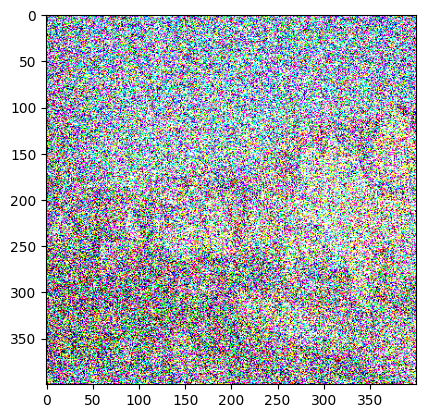

In [9]:
imsize = 400  

hall = style_transfer(
    content,
    style,
    np.ones((400, 400, 3)),
    np.ones((400, 400)),
    0,
    0,
    [36, 22 ],
    [4, 2, 1],
    imsize
)

plt.imshow(hall)